In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

device = torch.device("cpu")

iris=load_iris()

X, y=iris.data, iris.target

print(X.size, y.size)
print(X.dtype)


600 150
float64


In [2]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.tensor(y_test)

print(f"Train dataset size: {X_train_tensor.shape}")
print(f"Test dataset size: {X_test_tensor.shape}")


Train dataset size: torch.Size([120, 4])
Test dataset size: torch.Size([30, 4])


In [4]:
class IrisDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)


In [5]:
train_dataset = IrisDataset(X_train_tensor, y_train_tensor)
test_dataset = IrisDataset(X_test_tensor, y_test_tensor)

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [7]:
class IrisNeuralNetwork(nn.Module):
    def __init__(self, num_inputs=4, num_outputs=3):
        super().__init__()
        
        self.layers = nn.Sequential(
            # 1st layer (input)
            nn.Linear(num_inputs, 10),
            nn.ReLU(),
            
            # 2nd layer (hidden)
            nn.Linear(10, 10),
            nn.ReLU(),
            
            # 3rd layer (output)
            nn.Linear(10, num_outputs)
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
torch.manual_seed(42)

model = IrisNeuralNetwork(num_inputs=4, num_outputs=3)
model = model.to(device)

# counting of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество параметров модели: {num_params}")

#optimizer and loss fuction
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Количество параметров модели: 193


In [9]:
#Training the model
num_epochs = 100

print("Start the training")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for (batch_idx, (x, y)) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        
        # Direct pass
        model_results = model(x)
        loss = criterion(model_results, y)
        
        # Reverse pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(model_results.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    avg_loss = epoch_loss / len(train_dataloader)
    accuracy = 100 * correct / total
    
    if (epoch + 1) % 20 == 0:
         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Start the training
Epoch [20/100], Loss: 1.0107, Accuracy: 56.67%
Epoch [40/100], Loss: 0.7636, Accuracy: 66.67%
Epoch [60/100], Loss: 0.4974, Accuracy: 80.83%
Epoch [80/100], Loss: 0.3966, Accuracy: 85.83%
Epoch [100/100], Loss: 0.3355, Accuracy: 89.17%


In [10]:
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

print("Model is testing")
with torch.no_grad():
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        test_total += y.size(0)
        test_correct += (predicted == y).sum().item()

test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_dataloader)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test loss: {avg_test_loss:.4f}')


Model is testing
Test Accuracy: 83.33%
Test loss: 0.3840


In [11]:
model.eval()
with torch.no_grad():
     first_batch = next(iter(test_dataloader))
     x, y=first_batch
     probabilities = torch.softmax(model(x),dim=1)
     predictions = torch.argmax(torch.softmax(model(x),dim=1), dim=1)
     print(f'First batch: probabilities: {probabilities}')
     print(f'predictions: {predictions}, class_type: {y}')


First batch: probabilities: tensor([[0.9714, 0.0187, 0.0100],
        [0.0270, 0.3596, 0.6134],
        [0.3699, 0.4418, 0.1883],
        [0.2590, 0.5125, 0.2285],
        [0.9768, 0.0150, 0.0082],
        [0.0435, 0.3957, 0.5608],
        [0.9844, 0.0100, 0.0056],
        [0.9533, 0.0311, 0.0156],
        [0.0088, 0.2269, 0.7643],
        [0.1296, 0.5516, 0.3188],
        [0.0020, 0.1370, 0.8610],
        [0.0029, 0.1254, 0.8717],
        [0.0041, 0.1634, 0.8325],
        [0.0465, 0.4188, 0.5347],
        [0.9681, 0.0209, 0.0110],
        [0.9660, 0.0223, 0.0116]])
predictions: tensor([0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0]), class_type: tensor([0, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0])


CNN AlexNet

In [1]:
import torch
from torch import nn
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device=torch.device('cpu')
torch.manual_seed(42)

In [3]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
img_transforms = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize(mean=[0.1307], std=[0.3081])])

train_data = torchvision.datasets.MNIST(root="./data", train=True, transform=img_transforms, download=True)
test_data = torchvision.datasets.MNIST(root="./data", train=False, transform=img_transforms, download=True)

train_dataloader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=512, shuffle=False, num_workers=0)

for batch_idx, (data, target) in enumerate(train_dataloader):
     print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}")
     break

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")
print(f"Number of batches per epoch: {len(train_dataloader)}")

Batch 0: data shape torch.Size([512, 1, 32, 32]), target shape torch.Size([512])
Train dataset size: 60000
Test dataset size: 10000
Number of batches per epoch: 118


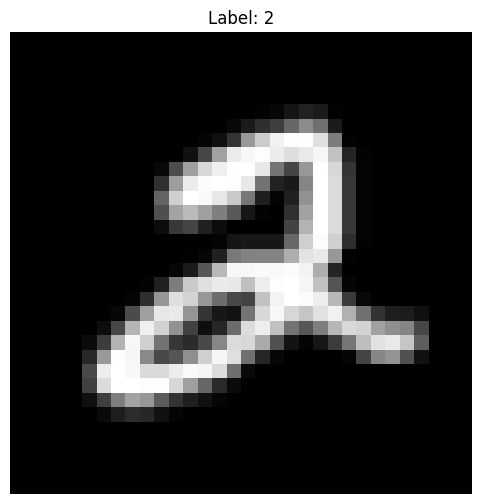

In [5]:
image, label = train_data[5]

plt.figure(figsize=(6, 6))
plt.imshow(image.squeeze(), cmap='gray')  # squeeze() убирает размерность канала
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [60]:
def build_alexnet():
    def init_weights(m):
        if type(m)==torch.nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        if type(m)==torch.nn.Conv2d:
            torch.nn.init.xavier_uniform(m.weight)

    net=torch.nn.Sequential(
        #input 1*32*32

        torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),  # 32x32 → 32x32
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 → 16x16

        torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # 16x16 → 16x16
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 → 8x8

        torch.nn.Flatten(),
        
        torch.nn.Linear(8*8*32, 64),  # 2048 → 64 
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # уменьшен dropout
        torch.nn.Linear(64, 10)
    )    
        
        # torch.nn.Conv2d(1, 32, kernel_size=3, padding=1), 
        # torch.nn.ReLU(inplace=True),
        # torch.nn.MaxPool2d(kernel_size=2),

        # torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
        # torch.nn.ReLU(inplace=True),
        # torch.nn.MaxPool2d(kernel_size=2),

        # # torch.nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
        # # torch.nn.ReLU(inplace=True),

        # # torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        # # torch.nn.ReLU(inplace=True),

        # # torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        # # torch.nn.ReLU(inplace=True),
        # # torch.nn.MaxPool2d(kernel_size=2, stride=2),

        # torch.nn.Flatten(),

        # torch.nn.Linear(64*8*8, 256),
        # torch.nn.ReLU(inplace=True),
        # torch.nn.Dropout(p=0.5),
        # # torch.nn.Linear(4096,4096),
        # # torch.nn.ReLU(inplace=True),
        # # torch.nn.Dropout(p=0.5),
        # torch.nn.Linear(4096,10)
        

    net.apply(init_weights)

    return net
    

In [61]:
alexnet = build_alexnet()
print(alexnet)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
)


C:\Users\titen\AppData\Local\Temp\ipykernel_23384\2488477073.py:7: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)
C:\Users\titen\AppData\Local\Temp\ipykernel_23384\2488477073.py:4: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


In [23]:
# define a train function
def train(net, train_loader, device, num_epochs, learning_rate):
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    for epoch in range(num_epochs):
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
          running_loss = 0.0
          correct = 0
          total = 0 
          for batch_num, (inputs, labels) in enumerate(train_loader):
               inputs = inputs.to(device)
               labels = labels.to(device)
               #inputs = inputs.permute(0, 3, 1, 2).to(device) if order is not correct
               
               optimizer.zero_grad()
               # Forward pass
               outputs = net(inputs)
               loss = loss_function(outputs, labels)
               # Backpropagation                
               loss.backward()
               #update
               optimizer.step()

               running_loss += loss.item()

               _, predicted = outputs.max(1)
               batch_total = labels.size(0)
               batch_correct = (predicted==labels).sum().item()
               batch_acc = batch_correct/batch_total

               pbar.set_postfix({
                   'Loss': f'{loss.item():.3f}',
                   'Acc': f'{batch_correct/batch_total:.3f}'})

               total += batch_total
               correct += batch_correct

        acc = correct/total 
        acc_history.append(acc)
        print(f"Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.3f}, Acc: {acc:.3f}")

    return acc_history


In [17]:
def print_history(history, title):
    plt.figure(figsize=(7,4))
    plt.plot(history)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


In [62]:
hist_alexnet = train(alexnet, train_dataloader, device, num_epochs=10, learning_rate=0.01)

Epoch 1/10:   0%|                                                                                                                   | 0/118 [01:14<?, ?it/s, Loss=0.263, Acc=0.896]


Epoch 1: Loss: 0.819, Acc: 0.728


Epoch 2/10:   0%|                                                                                                                   | 0/118 [01:10<?, ?it/s, Loss=0.125, Acc=0.979]


Epoch 2: Loss: 0.249, Acc: 0.926


Epoch 3/10:   0%|                                                                                                                   | 0/118 [01:12<?, ?it/s, Loss=0.090, Acc=0.969]


Epoch 3: Loss: 0.176, Acc: 0.948


Epoch 4/10:   0%|                                                                                                                   | 0/118 [01:13<?, ?it/s, Loss=0.072, Acc=0.990]


Epoch 4: Loss: 0.141, Acc: 0.959


Epoch 5/10:   0%|                                                                                                                   | 0/118 [01:15<?, ?it/s, Loss=0.174, Acc=0.938]


Epoch 5: Loss: 0.126, Acc: 0.962


Epoch 6/10:   0%|                                                                                                                   | 0/118 [01:14<?, ?it/s, Loss=0.198, Acc=0.948]


Epoch 6: Loss: 0.108, Acc: 0.968


Epoch 7/10:   0%|                                                                                                                   | 0/118 [01:15<?, ?it/s, Loss=0.101, Acc=0.958]


Epoch 7: Loss: 0.100, Acc: 0.970


Epoch 8/10:   0%|                                                                                                                   | 0/118 [01:15<?, ?it/s, Loss=0.045, Acc=1.000]


Epoch 8: Loss: 0.091, Acc: 0.973


Epoch 9/10:   0%|                                                                                                                   | 0/118 [01:14<?, ?it/s, Loss=0.065, Acc=0.990]


Epoch 9: Loss: 0.085, Acc: 0.974


Epoch 10/10:   0%|                                                                                                                  | 0/118 [01:14<?, ?it/s, Loss=0.089, Acc=0.979]

Epoch 10: Loss: 0.078, Acc: 0.977


In [56]:
hist_alexnet = train(alexnet, train_dataloader, device, num_epochs=10, learning_rate=0.01)

Epoch 1/10:   0%|                                                                                                                   | 0/118 [09:50<?, ?it/s, Loss=0.279, Acc=0.938]


Epoch 1: Loss: 0.358, Acc: 0.883


Epoch 2/10:   0%|                                                                                                                   | 0/118 [09:56<?, ?it/s, Loss=0.160, Acc=0.938]


Epoch 2: Loss: 0.155, Acc: 0.951


Epoch 3/10:   0%|                                                                                                                   | 0/118 [00:35<?, ?it/s, Loss=0.169, Acc=0.939]


KeyboardInterrupt: 

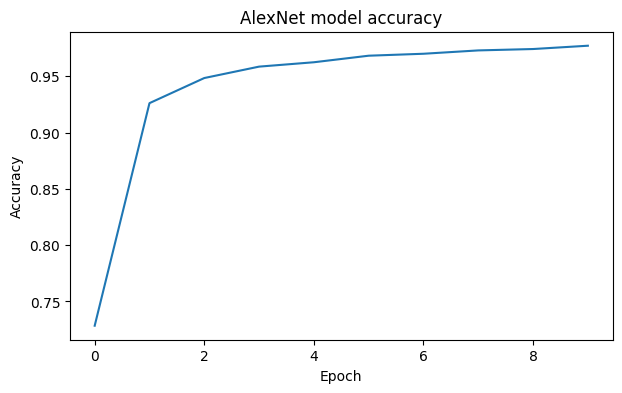

In [63]:
print_history(hist_alexnet, "AlexNet model accuracy")

In [18]:
def evaluate_acc(net, test_dataloader, device=device):
    total=0
    correct=0
    for batch_num, (inputs, labels) in enumerate(test_dataloader):
        inputs=inputs.to(device)
        labels=labels.to(device)

        outputs=net(inputs)
        _,predicted=outputs.max(1)

        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    acc=correct/total
    return acc

In [19]:
print('Test Accuracy (AlexNet): {:.2%}'.format(evaluate_acc(alexnet, test_dataloader,device))

_IncompleteInputError: incomplete input (455063119.py, line 1)

LeNet

In [29]:
def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), torch.nn.ReLU(),
        
        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), torch.nn.ReLU(),
        
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)), torch.nn.ReLU(),

        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), 
        
        torch.nn.Flatten(),
        
        torch.nn.Linear(6*6*16, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net


In [30]:
lenet=build_lenet()
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=576, out_features=120, bias=True)
  (9): ReLU()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [32]:
hist_lenet = train(lenet, train_dataloader, device, num_epochs=10, learning_rate=0.01)

Epoch 1/10:   0%|                                                                                                                   | 0/118 [00:51<?, ?it/s, Loss=0.073, Acc=0.979]


Epoch 1: Loss: 0.116, Acc: 0.970


Epoch 2/10:   0%|                                                                                                                   | 0/118 [00:47<?, ?it/s, Loss=0.091, Acc=0.990]


Epoch 2: Loss: 0.098, Acc: 0.975


Epoch 3/10:   0%|                                                                                                                   | 0/118 [00:46<?, ?it/s, Loss=0.083, Acc=0.969]


Epoch 3: Loss: 0.086, Acc: 0.977


Epoch 4/10:   0%|                                                                                                                   | 0/118 [00:47<?, ?it/s, Loss=0.168, Acc=0.958]


Epoch 4: Loss: 0.078, Acc: 0.979


Epoch 5/10:   0%|                                                                                                                   | 0/118 [00:47<?, ?it/s, Loss=0.034, Acc=0.990]


Epoch 5: Loss: 0.070, Acc: 0.981


Epoch 6/10:   0%|                                                                                                                   | 0/118 [00:46<?, ?it/s, Loss=0.037, Acc=0.990]


Epoch 6: Loss: 0.064, Acc: 0.983


Epoch 7/10:   0%|                                                                                                                   | 0/118 [00:45<?, ?it/s, Loss=0.078, Acc=0.979]


Epoch 7: Loss: 0.059, Acc: 0.984


Epoch 8/10:   0%|                                                                                                                   | 0/118 [00:46<?, ?it/s, Loss=0.081, Acc=0.979]


Epoch 8: Loss: 0.055, Acc: 0.985


Epoch 9/10:   0%|                                                                                                                   | 0/118 [00:46<?, ?it/s, Loss=0.057, Acc=0.990]


Epoch 9: Loss: 0.051, Acc: 0.986


Epoch 10/10:   0%|                                                                                                                  | 0/118 [00:47<?, ?it/s, Loss=0.115, Acc=0.958]

Epoch 10: Loss: 0.048, Acc: 0.987


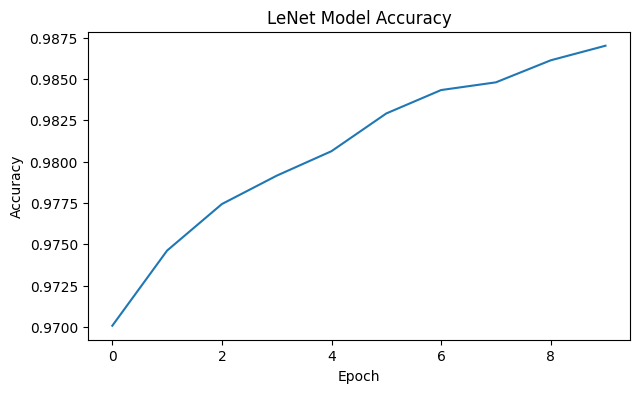

In [33]:
print_history(hist_lenet, "LeNet Model Accuracy")

In [65]:
print('Test Accuracy (AlexNet): {:.2%}'.format(evaluate_acc(alexnet, test_dataloader,device)))
print('Test Accuracy (LeNet): {:.2%}'.format(evaluate_acc(lenet, test_dataloader,device)))

Test Accuracy (AlexNet): 97.67%
Test Accuracy (LeNet): 98.55%
